In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [273]:
!pip install contractions

     |████████████████████████████████| 238 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 312 kB 34.4 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp37-cp37m-macosx_10_9_x86_64.whl size=29373 sha256=47220a4a3b3ff23b3ee2de13a30f8e5a03a0a80acb82a74e2f78091c97ea4f0e
  Stored in directory: /Users/omni/Library/Caches/pip/wheels/9b/6b/f7/62dc8caf183b125107209c014e78c340a0b4b7b392c23c2db4
Successfully built pyahocorasick


In [2]:
import contractions

In [3]:
DATA_DIRECTORY = 'dataset'


# First dataset is davidson dataset 
https://www.kaggle.com/eldrich/hate-speech-offensive-tweets-by-davidson-et-al

In [158]:
DAVIDSON_DIR = 'davidson'
RAW_DATA = os.path.join(DATA_DIRECTORY, DAVIDSON_DIR, "labeled_data.csv")

In [159]:
# Decided to pull in column headers from the file instead of explicitly in case the file were to change
tweets = pd.read_csv(RAW_DATA)

In [160]:
tweets.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [161]:
# Rename unnamed column to id
tweets = tweets.rename(columns={'Unnamed: 0':'id'})

In [162]:
# Originally we were going to use an arbitrary index.  However, we are going to use id as a supplimental one 
#tweets.index = tweets.id
#tweets = tweets.drop('id', axis=1)

In [163]:
tweets.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [164]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## Data exploration

#### First make sure the values are all within correct ranges

In [165]:
tweets[tweets['count'] < 1].count() # No Reviews

id                    0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [166]:
tweets[(tweets['class'] > 2) | (tweets['class'] < 0)].count() # Bad class values

id                    0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [167]:
tweets.head(20)

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [168]:
tweets.index.max()

24782

### Classes are extremely disproportional

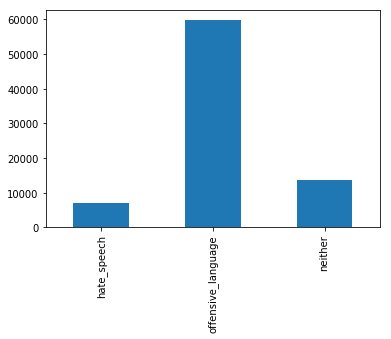

In [169]:
tweets[['hate_speech', 'offensive_language', 'neither']].sum().plot(kind='bar')

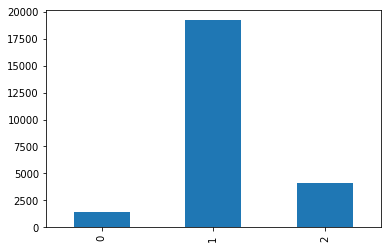

In [170]:
tweets['class'].value_counts().sort_index().plot(kind='bar')


### Controversial ones
required more people to vote on them

In [171]:
tweets[tweets['count'] > 3].head(10)

,id,count,hate_speech,offensive_language,neither,class,tweet
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
80,80,9,0,7,2,1,"""@BestProAdvice: The facts on tattoos...tattoo..."
91,92,6,1,5,0,1,"""@CHlLDHOODRUINER: when ur teacher tells u tha..."
127,128,6,0,6,0,1,"""@GTM_Al: Ya side bitch gotta know it's rules ..."
133,134,6,0,6,0,1,"""@Gizzy_Jones94: If she kiss u with her eyes o..."
137,138,6,0,6,0,1,"""@HBMostDope: Ugly bitches be like I'm my own ..."
151,153,6,0,6,0,1,"""@JasminePore: If you dressed up as a cat for ..."
152,154,4,0,4,0,1,"""@Jewelxo: Can pornhub just get a gaming strea..."
155,157,6,0,6,0,1,"""@KazAtta: @1TAKEHOV Oh man.. ""its 5 am, you o..."
171,173,6,0,6,0,1,"""@LeBronVuitton: A loyal bitch from the burbs ..."


In [172]:
tweets[tweets['count'] > 3].count()

id                    1976
count                 1976
hate_speech           1976
offensive_language    1976
neither               1976
class                 1976
tweet                 1976
dtype: int64

In [173]:
tweets.iloc[92].tweet

'"@CaelanG15: "@22EdHam: @CaelanG15 that nigga was eating that hoe lol" Hell Yea lol john Paul" nigga said john paul.. http://t.co/OSIpBKPr9h'

# Second dataset to balance out the data some
Random kaggle hate speech dataset: https://www.kaggle.com/mohit28rawat/hate-speech

The point of this dataset is to get more inoffensive and hate speech examples to add to the overall dataset

In [174]:
HATE_SPEECH_DIR = 'hate-speech'
RAW_DATA2 = os.path.join(DATA_DIRECTORY, HATE_SPEECH_DIR, "labels.csv")

In [175]:
hs_tweets = pd.read_csv(RAW_DATA2)

In [176]:
hs_tweets.head()

,Index,Tweet,Class
0,1,@guccitwist i should be killed for being a whi...,1
1,2,RT @DipOnline I be closing my eyes and shit so...,1
2,3,Par billi se.....kabhi nhi.I hate cat https://...,0
3,4,"@LILBTHEBASEDGOD ""I'm a dirty ass nigga with a...",1
4,5,the army life _‰ã¢ÌöÌÏ,2


In [177]:
# Create new index outside of the range of the previous one
hs_tweets['id'] = hs_tweets['Index'] + 100000

In [178]:
hs_tweets.head()

,Index,Tweet,Class,id
0,1,@guccitwist i should be killed for being a whi...,1,100001
1,2,RT @DipOnline I be closing my eyes and shit so...,1,100002
2,3,Par billi se.....kabhi nhi.I hate cat https://...,0,100003
3,4,"@LILBTHEBASEDGOD ""I'm a dirty ass nigga with a...",1,100004
4,5,the army life _‰ã¢ÌöÌÏ,2,100005


In [182]:
hs_tweets = hs_tweets.drop('Index', axis=1)

In [183]:
hs_tweets.head()

,Tweet,Class,id
0,@guccitwist i should be killed for being a whi...,1,100001
1,RT @DipOnline I be closing my eyes and shit so...,1,100002
2,Par billi se.....kabhi nhi.I hate cat https://...,0,100003
3,"@LILBTHEBASEDGOD ""I'm a dirty ass nigga with a...",1,100004
4,the army life _‰ã¢ÌöÌÏ,2,100005


In [184]:
hs_tweets['Class'].value_counts()

1     24026
2     14351
0      5489
on        2
n         2
Name: Class, dtype: int64

In [185]:
hs_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43870 entries, 0 to 43869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   43870 non-null  object
 1   Class   43870 non-null  object
 2   id      43870 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [186]:
hs_tweets[~hs_tweets['Class'].str.isnumeric()]

,Tweet,Class,id
14135,Mohabbat Tum Se Nafrat Hai Episode 11 18 june ...,n,114136
16854,pagal person..solder ko bolte hai ki jate q ho...,on,116855
28366,6yrs me nikah,n,128367
29713,I agree with @shoaib100mph,on,129714


In [187]:
# Drop the 4 and reset the type
hs_tweets = hs_tweets[hs_tweets['Class'].str.isnumeric()]

In [188]:
hs_tweets.Class = hs_tweets.Class.astype('int32')

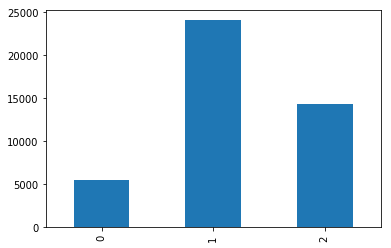

In [189]:
hs_tweets['Class'].value_counts().sort_index().plot(kind='bar')

In [190]:
hs_tweets.dtypes

Tweet    object
Class     int32
id        int64
dtype: object

In [191]:
hs_tweets.head()

,Tweet,Class,id
0,@guccitwist i should be killed for being a whi...,1,100001
1,RT @DipOnline I be closing my eyes and shit so...,1,100002
2,Par billi se.....kabhi nhi.I hate cat https://...,0,100003
3,"@LILBTHEBASEDGOD ""I'm a dirty ass nigga with a...",1,100004
4,the army life _‰ã¢ÌöÌÏ,2,100005


In [192]:
hs_tweets[hs_tweets['Class'] == 0][:20]

,Tweet,Class,id
2,Par billi se.....kabhi nhi.I hate cat https://...,0,100003
5,Some niggas like fendi.,0,100006
19,"Modiji ji andhaKanun badlo,70sal purana abi cc...",0,100020
33,@KylahTernauxx ARM WRESTLING IS FOR LITTLE FAG...,0,100034
44,RT @No_ahhh23: Happy birthday faggot! &#128536...,0,100045
54,idk what games james played on it. if it playe...,0,100055
65,@yung_davaron porch monkey!!1!,0,100066
71,kya faltu bayaan hai.. Bengal sabhi ka rape ho...,0,100072
73,Khud ko rape karwake...,0,100074
83,@IAmSteveHarvey Answering something wrong in a...,0,100084


In [194]:
hs_tweets.loc[10].Tweet

'The girl skipping school ain\'t nothing but 16 y/o and just made me say in my head "bitch u supposed to be in school" had to catch myself'

In [195]:
hs_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43866 entries, 0 to 43869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   43866 non-null  object
 1   Class   43866 non-null  int32 
 2   id      43866 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 2.4+ MB


In [196]:
hs_tweets[hs_tweets['Tweet'].str.len() < 1]

,Tweet,Class,id


In [197]:
# Rename columns to be uniform with first dataset
hs_tweets = hs_tweets.rename(columns={'Tweet':'tweet', 'Class': 'class'})

# Now we need to combine the datasets

We are going to only combine the hate speech and innocuous tweets but leave out offensive ones in hopes of balancing out the large class

In [198]:
tweets.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [199]:
hs_tweets.head()

,tweet,class,id
0,@guccitwist i should be killed for being a whi...,1,100001
1,RT @DipOnline I be closing my eyes and shit so...,1,100002
2,Par billi se.....kabhi nhi.I hate cat https://...,0,100003
3,"@LILBTHEBASEDGOD ""I'm a dirty ass nigga with a...",1,100004
4,the army life _‰ã¢ÌöÌÏ,2,100005


#### We only want more hate speech examples (class == 0) and ordinary examples (class == 2) from the second dataset

In [200]:
hs_tweets_reduced = hs_tweets[hs_tweets['class'] != 1]

#### Pulling only the 3 columns we want to us from the davidson dataset

In [201]:
davidon_reduced = tweets[['class', 'tweet', 'id']]

In [202]:
davidon_reduced.head()

,class,tweet,id
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,3
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4


In [203]:
combined = pd.concat([davidon_reduced, hs_tweets_reduced])

In [204]:
combined.count()

class    44623
tweet    44623
id       44623
dtype: int64

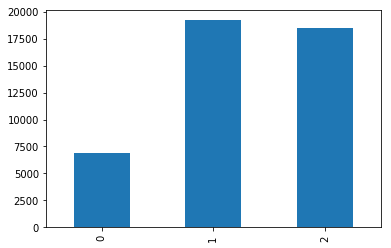

In [205]:
combined['class'].value_counts().sort_index().plot(kind="bar")

### Create pickle dump of the dataframe

In [4]:
DUMP_FILE = "combined_data.p"

In [207]:
pickle.dump(combined, open(os.path.join(DATA_DIRECTORY, DUMP_FILE), "wb"))